In [28]:
import os
import cv2
import torch
import tqdm
import scipy
import numpy as np
import matplotlib.pyplot as plt
from molscribe import MolScribe
from sklearn.decomposition import PCA

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
print(use_cuda, device)

True cuda:0


In [3]:
model_path = 'ckpts/swin_base_char_aux_1m680k.pth'

#input_dir = 'assets'
#list_image_path = [os.path.join(input_dir, filename) for filename in sorted(os.listdir(input_dir)) if 'example' in filename]

input_dir = 'DECIMER_HDM_Dataset_Images'
list_image_path = [os.path.join(input_dir, filename) for filename in sorted(os.listdir(input_dir))]

# Load a pretrained model

In [4]:
model = MolScribe(model_path, device)

/home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Read image files

In [5]:
def read_image_file(filepath):
    image = cv2.imread(filepath)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
images = []
for filepath in tqdm.tqdm(list_image_path):
    image = read_image_file(filepath)
    images.append(image)

print(f"Number of images: {len(images)}")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5088/5088 [00:12<00:00, 403.45it/s]

Number of images: 5088


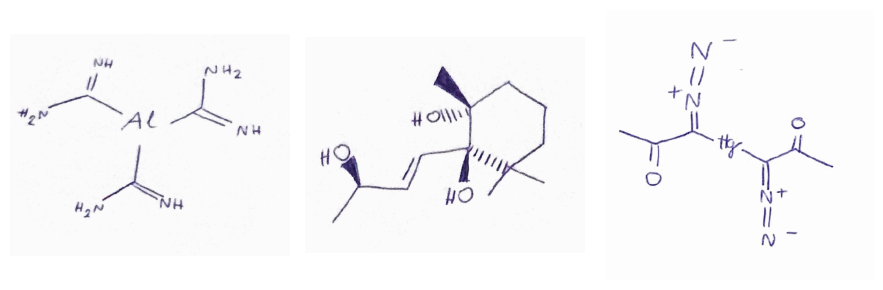

In [7]:
fig, ax = plt.subplots(1,3,figsize=(9,3))

for i in range(3):
    ax[i].imshow(images[i])
    ax[i].axis('off')
    
plt.tight_layout()
plt.show()

# Predict

In [9]:
outputs = model.predict_features(images, batch_size=128, reduction='mean', use_tqdm=True)

  0%|                                                                                                                                                                                                         | 0/40 [00:00<?, ?it/s]/home/descartes/miniconda3/envs/molscribe/lib/python3.9/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [02:11<00:00,  3.30s/it]


In [10]:
outputs = np.array(outputs)

In [11]:
outputs.shape

(5088, 144)

# PCA

In [12]:
pca = PCA(n_components=2, random_state=2023).fit(outputs)

In [13]:
points = pca.transform(outputs)

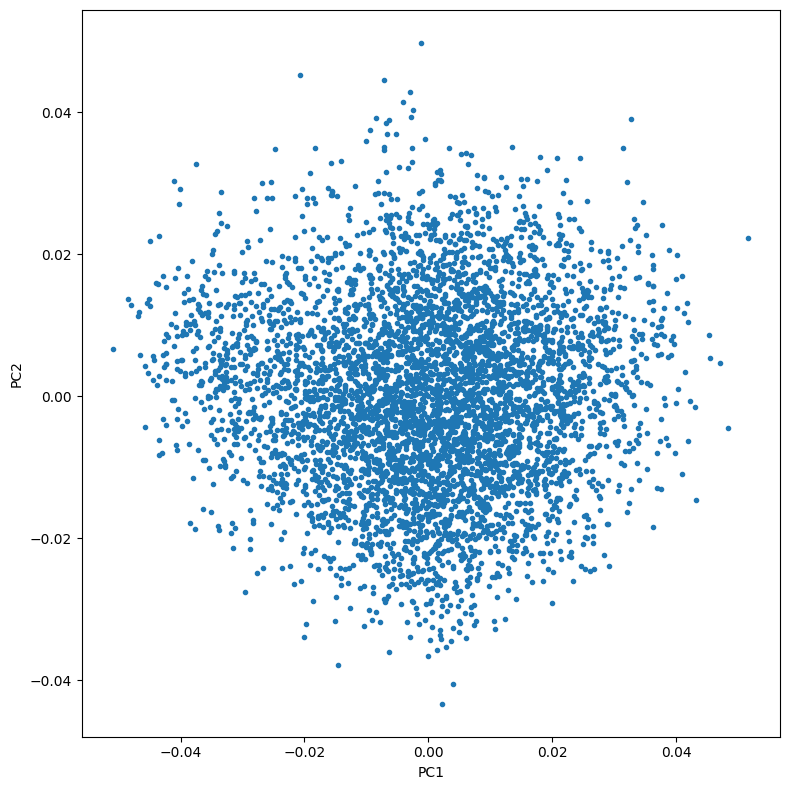

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.scatter(points[:,0], points[:,1], marker='.', label='Training data')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

plt.tight_layout()
plt.show()

# Gaussian distribution fitting

In [19]:
mu = np.mean(outputs, axis=0)
sigma = np.cov(outputs, rowvar=False)

In [20]:
mu.shape

(144,)

In [22]:
sigma.shape

(144, 144)

# Frechet Inception Distance

In [31]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [32]:
calculate_fid(outputs[:2500], outputs[2500:])

9.155765855777539e-05